In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

np.random.seed(0)

# Import Data

Current Training Data includes SPF survey responses and price for specific items

In [119]:
data = pd.read_csv("../data/TrainingData/trainingWithItems.csv")#,index_col=0) 
data.head()
data.columns

Index(['YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST', 'INDICATOR',
       'FORECASTER ID', 'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 12', 'BIN 13', 'BIN 14', 'BIN 15', 'BIN 1 prob',
       'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
       'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
       'BIN 12 prob', 'BIN 13 prob', 'BIN 14 prob', 'BIN 15 prob',
       'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
       'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
       'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint',
       'BIN 12 midpoint', 'BIN 13 midpoint', 'BIN 14 midpoint',
       'BIN 15 midpoint', 'nbin', 'bin_value_sum', 'TDIST', 'actual',
       'ACTUAL_BIN', 'MAX', 'NUM_OF_MAX', 'ACTUAL_CONF', 'HI

Goal: Find feature importance of items for Xgboost and hopefully more models too!

# Train Test Split

In [120]:
# relevant=data[data["YEAR FORECAST MADE"]>=1984].loc[:,["INDICATOR",'FORECASTER ID', 'MAX', 'ACTUAL_CONF', 'HIT', 'pred_average',
#        'pred_var', 'banana', 'beef', 'bread', 'chicken', 'coffee', 'eggs',
#        'electricity', 'flour', 'rice', 'unleadedGasoline','actual']]
relevant=data[data["YEAR FORECAST MADE"]>=1984].drop(columns = ['YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST',  'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 12', 'BIN 13', 'BIN 14', 'BIN 15', 'BIN 1 prob',
       'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
       'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
       'BIN 12 prob', 'BIN 13 prob', 'BIN 14 prob', 'BIN 15 prob',
       'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
       'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
       'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint',
       'BIN 12 midpoint', 'BIN 13 midpoint', 'BIN 14 midpoint',
       'BIN 15 midpoint', 'nbin', 'bin_value_sum', 'TDIST',
       'ACTUAL_BIN', 'NUM_OF_MAX',"FORECASTER ID"])
relevant.dropna()

,INDICATOR,actual,MAX,ACTUAL_CONF,HIT,pred_average,pred_var,banana,beef,bread,chicken,coffee,eggs,electricity,flour,iceCream,rice,unleadedGasoline
3460,RealGNP,7.10641,0.750,0.25,0.0,5.500,0.750000,0.363333,1.312667,0.5420,0.851333,2.529,1.259333,0.078667,0.215,2.183667,0.481667,1.211667
3461,RealGNP,7.10641,0.400,0.10,0.0,3.000,8.800000,0.363333,1.312667,0.5420,0.851333,2.529,1.259333,0.078667,0.215,2.183667,0.481667,1.211667
3462,RealGNP,7.10641,0.500,0.20,0.0,4.500,3.950000,0.363333,1.312667,0.5420,0.851333,2.529,1.259333,0.078667,0.215,2.183667,0.481667,1.211667
3463,RealGNP,7.10641,0.500,0.00,0.0,3.600,2.440000,0.363333,1.312667,0.5420,0.851333,2.529,1.259333,0.078667,0.215,2.183667,0.481667,1.211667
3464,RealGNP,7.10641,0.350,0.25,0.0,4.000,7.400000,0.363333,1.312667,0.5420,0.851333,2.529,1.259333,0.078667,0.215,2.183667,0.481667,1.211667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36057,Unemployment,0.00000,0.299,0.00,0.0,5.514,0.578179,0.602000,4.098500,1.5105,1.500500,4.659,1.622500,0.139500,0.438,4.831500,0.793000,2.905500
36058,Unemployment,0.00000,0.500,0.00,0.0,5.125,0.203125,0.602000,4.098500,1.5105,1.500500,4.659,1.622500,0.139500,0.438,4.831500,0.793000,2.905500
36059,Unemployment,0.00000,0.500,0.00,0.0,5.125,0.203125,0.602000,4.098500,1.5105,1.500500,4.659,1.622500,0.139500,0.438,4.831500,0.793000,2.905500
36060,Unemployment,0.00000,0.900,0.00,0.0,5.175,0.050625,0.602000,4.098500,1.5105,1.500500,4.659,1.622500,0.139500,0.438,4.831500,0.793000,2.905500


In [121]:
X_train,X_test,y_train,y_test = train_test_split(relevant.drop(columns = ["actual","INDICATOR"]),relevant["actual"],test_size=.3,random_state=42,stratify=relevant["INDICATOR"])

# Model Creation

In [122]:
xgboost_regressor = xgb.XGBRegressor(verbosity = 0)
random_forest_regressor = RandomForestRegressor(n_estimators=100)

# Item Importance


In [123]:
random_forest_regressor.fit(X_train, y_train)

RandomForestRegressor()

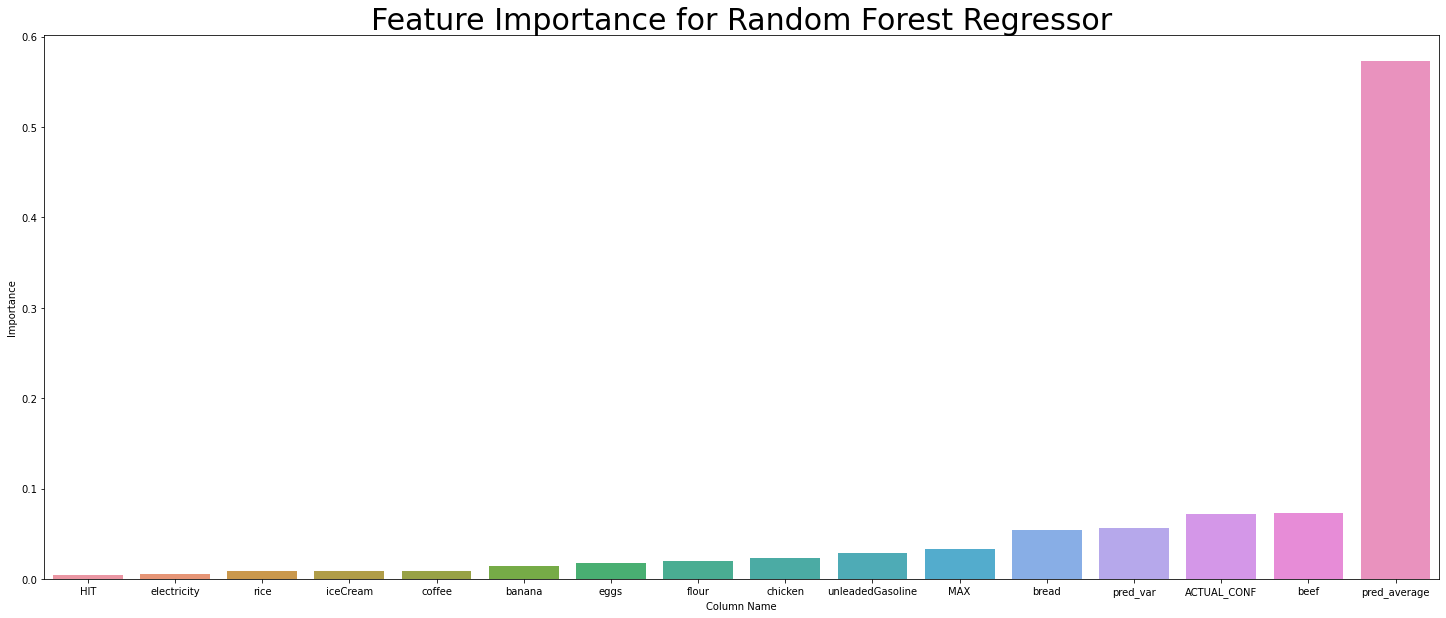

In [124]:
fig,axs = plt.subplots(1,1,figsize=(25,10))
sorted_scores = random_forest_regressor.feature_importances_.argsort()
sns.barplot(x=X_train.columns[sorted_scores],y=random_forest_regressor.feature_importances_[sorted_scores])
plt.xlabel("Column Name")
plt.ylabel("Importance")
plt.title("Feature Importance for Random Forest Regressor",size=30);

Feature importance is created using Gini importance or mean decrease impurity. This is a measure of the average decrease in impurity a feature contributes averaged over all trees in the random forest! There are other measures as well which I want to consider

Next: Do for ensemble model